In [2]:
import mib as mb1
import mib_v2 as mb
import matplotlib.pyplot as plt
import time
from itertools import product
import tracemalloc

# Problema de prueba 1

## Planteamiento
Genarar una grafica del rendimiento del motor de inferencia con problema pequeño y con tres eventon con distribuciones uniformes, donde su cardinalidad de los tres va de uno a cien.


### Variables
A = \{0, 2, ..., n-1\}

B = \{0, 2, ..., n-1\}

C = \{0, 2, ..., n-1\}

### Modelo de descomposición
$P(ABC) = P(A)P(B|A)P(C|AB)$.

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./P(ABC).jpg" width=200/>

### Formas 

$P(A)$, $P(B|A)$ y $P(C|AB)$ serán distribuciones uniformes.

## Test

### Comprobación de generación de distribuciones 

In [3]:
i = 10
dA = {}
dB_A = {}
dC_AB = {}
value = 1 / (i)
for x in range(i):
    dA[x] = value
    dB_A[(x,)] = {}
    for y in range(i):
        dB_A[(x,)][y] = value
        dC_AB[(x,y)] = {}
        for z in range(i):
            dC_AB[(x,y)][z] = value

var = [j for j in range(i)]
vars = [var, var, var]
sum = 0

for x,y,z in product(*vars):
    p = dA[x] * dB_A[(x,)][y] * dC_AB[(x,y)][z]
    sum += p
print(sum)

1.0000000000000007


### MIB1.0

In [3]:
n = 10
timesM1 = []
memoryM1 = []

timesC1 = []
memoryC1 = []

for i in range(n):
    Events = [x for x in range(i+1)]
    # Varaibles
    A = mb1.Var('A',Events)
    B = mb1.Var('B',Events)
    C = mb1.Var('C',Events)

    dA = {}
    dB_A = {}
    dC_AB = []
    value = 1 / (i+1)
    for e in Events:
        dA[e] = value
        dB_A[e] = {}
        for e1 in Events:
            dB_A[e][e1] = value
            tC_AB = []
            for e2 in Events:
                tC_AB.append(value)
            dC_AB.append(tuple(tC_AB))
    
    PA=mb1.Distrib(name='P(A)',variable=[A],tabla=dA)
    PB_A=mb1.DistribCond(name='P(B|A)',var=B,indep=[A],tabla=dB_A)
    PC_AB=mb1.DistribCond('P(C|AB)',C,[A,B],dC_AB)
    
    PABC=mb1.JointDistrib(name='P(ABC)',variables=[A,B,C],descomp=[PA,PB_A,PC_AB])
    Q_ABC=mb1.Question(joint=PABC)

    #Inferencia de P(B)
    tracemalloc.start()
    
    inicio = time.time()
    PB = Q_ABC.query(searched=[B])
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesM1.append(tiempo_ejecucion)
    memoryM1.append(memoria_pico)
    
    #Inferencia de P(A|BC)
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = Q_ABC.query(searched=[A], known=[B,C])
    fin = time.time() 
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC1.append(tiempo_ejecucion)
    memoryC1.append(memoria_pico)

### MIB2.0

In [4]:
n = 10
timesM = []
memoryM = []

timesC = []
memoryC = []

for i in range(n):
    Events = set([x for x in range(i+1)])
    
    # Generación de distribuciones de probabilidad (Distribuciones uniformes).
    dA = {}
    dB_A = {}
    dC_AB = {}
    value = 1 / (i+1)
    for x in range(i+1):
        dA[x] = value
        dB_A[(x,)] = {}
        for y in range(i+1):
            dB_A[(x,)][y] = value
            dC_AB[(x,y)] = {}
            for z in range(i+1):
                dC_AB[(x,y)][z] = value
    
    # Variables para el motor de inferencia.
    A = mb.Var(Events)
    PA = mb.Distrib(A,dA)
    B = mb.Var(Events)
    PB_A = mb.CondDistrib(B,set([A]),dB_A)
    C = mb.Var(Events)
    PC_AB = mb.CondDistrib(C,set([A,B]),dC_AB)
    
    # Probabilidad conjunta (modelo)
    PABC = mb.Model(set([A,B,C]), set([PA, PB_A, PC_AB]))

    # Motor de inferencia
    mib = mb.Mib(PABC)
    
    # Inferencia de una marginal
    tracemalloc.start()
    
    inicio = time.time()
    PB = mib.Marginal_inference(B)
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    tiempo_ejecucion = fin - inicio
    
    timesM.append(tiempo_ejecucion)
    memoryM.append(memoria_pico)
    
    # Inferencia de una condicional dada observaciones
    tracemalloc.start()
    
    inicio = time.time()
    PA_BC = mib.Cond_Dist(A, set([B,C]))
    fin = time.time()
    
    memoria_actual, memoria_pico = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    
    tiempo_ejecucion = fin - inicio
    
    timesC.append(tiempo_ejecucion)
    memoryC.append(memoria_pico)

In [5]:
xn = [i+1 for i in range(n)]


### Tiempo de la inferencia en P(B)

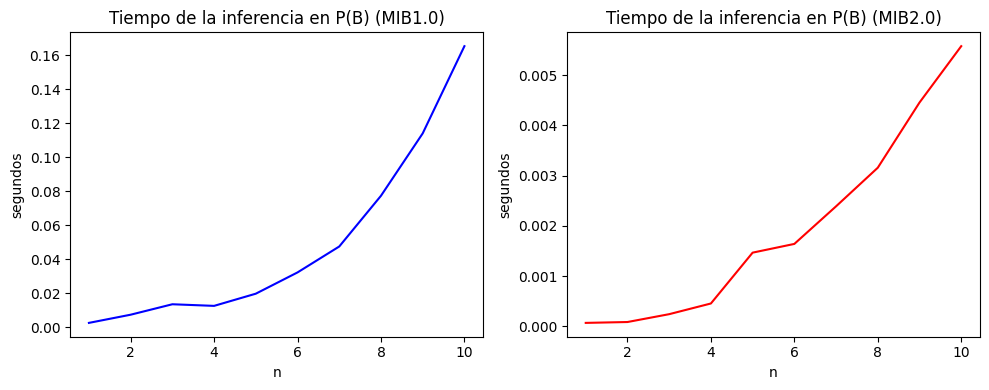

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 fila, 2 columnas

# Primera gráfica (izquierda)
axs[0].plot(xn, timesM1, color='b')
axs[0].set_title("Tiempo de la inferencia en P(B) (MIB1.0)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("segundos")

# Segunda gráfica (derecha)
axs[1].plot(xn, timesM, color='r')
axs[1].set_title("Tiempo de la inferencia en P(B) (MIB2.0)")
axs[1].set_xlabel("n")
axs[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.tight_layout()  # Ajusta el espaciado para que no se superpongan
plt.show()

### Memoria de la inferencia en P(B)

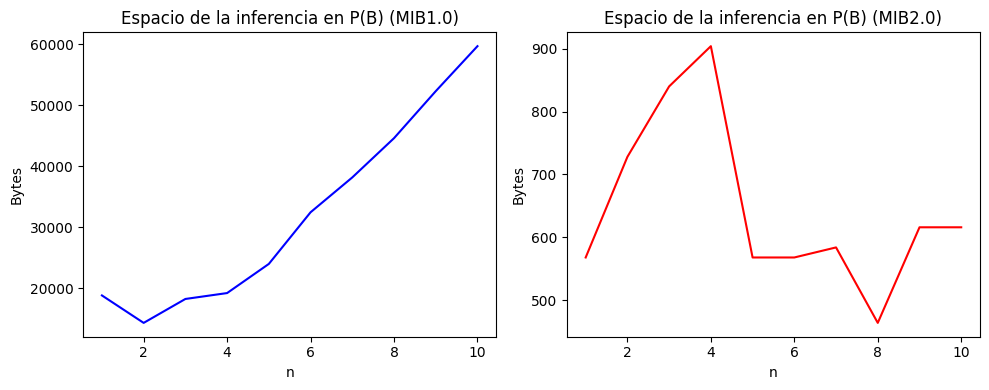

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 fila, 2 columnas

# Primera gráfica (izquierda)
axs[0].plot(xn, memoryM1, color='b')
axs[0].set_title("Espacio de la inferencia en P(B) (MIB1.0)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("Bytes")

# Segunda gráfica (derecha)
axs[1].plot(xn, memoryM, color='r')
axs[1].set_title("Espacio de la inferencia en P(B) (MIB2.0)")
axs[1].set_xlabel("n")
axs[1].set_ylabel("Bytes")

# Mostrar las gráficas
plt.tight_layout()  # Ajusta el espaciado para que no se superpongan
plt.show()

### Tiempo de la inferencia de P(A|BC)

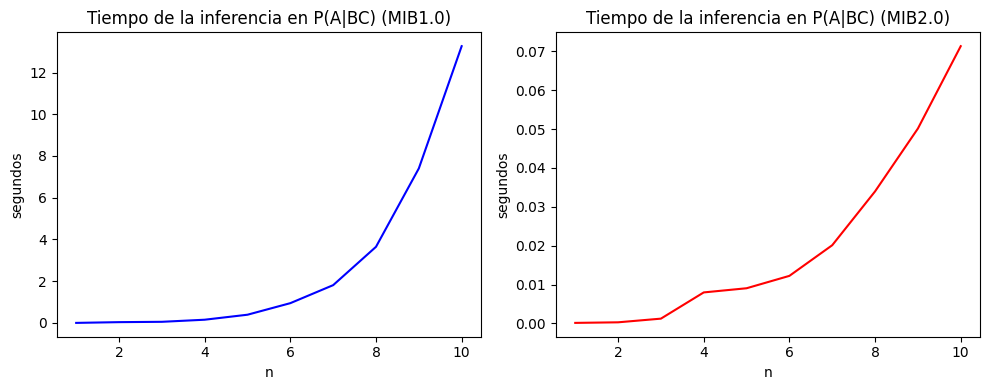

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 fila, 2 columnas

# Primera gráfica (izquierda)
axs[0].plot(xn, timesC1, color='b')
axs[0].set_title("Tiempo de la inferencia en P(A|BC) (MIB1.0)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("segundos")

# Segunda gráfica (derecha)
axs[1].plot(xn, timesC, color='r')
axs[1].set_title("Tiempo de la inferencia en P(A|BC) (MIB2.0)")
axs[1].set_xlabel("n")
axs[1].set_ylabel("segundos")

# Mostrar las gráficas
plt.tight_layout()  # Ajusta el espaciado para que no se superpongan
plt.show()

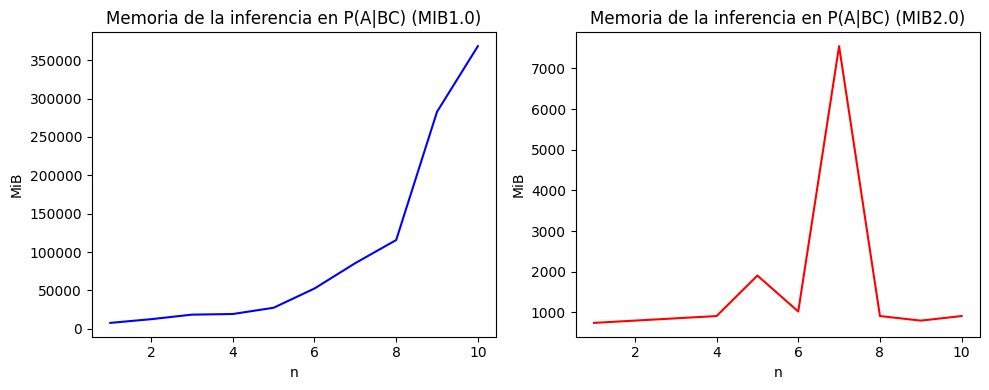

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 fila, 2 columnas

# Primera gráfica (izquierda)
axs[0].plot(xn, memoryC1, color='b')
axs[0].set_title("Memoria de la inferencia en P(A|BC) (MIB1.0)")
axs[0].set_xlabel("n")
axs[0].set_ylabel("MiB")

# Segunda gráfica (derecha)
axs[1].plot(xn, memoryC, color='r')
axs[1].set_title("Memoria de la inferencia en P(A|BC) (MIB2.0)")
axs[1].set_xlabel("n")
axs[1].set_ylabel("MiB")

# Mostrar las gráficas
plt.tight_layout()  # Ajusta el espaciado para que no se superpongan
plt.show()

# Problema de prueba 2

## Plantemiento 

Se tiene un conjunto de correos, en los cuales se sabe si son spam o no, y se quiere saber si dada las palabras presentes en el correo el correo pertenece a spam.

### Variables


* $Spam := \{0,1\}$
* $W_i = \{0,1\}$

* $P(Spam = 0) = 0.25$
* $P(Spam = 1) = 0.75$

### Modelo de descomposición

#### Conjunta
$P(Spam W_0 W_1 ... W_n ) = P(Spam)\prod_i P(W_i|Spam)$.

Cada una de las $n$ formas de $P(W_i|Spam)$ debe ser espacificado. Para el conteo de la i-ésima palabra que aparesca spam y no spam 

* $P(W_i|Spam)$
    * $P(W_i = true | Spam = false) = \frac{1 + {n^i}_f}{|W_i| + n_f}$
    * $P(W_i = true | Spam = true) = \frac{1 + {n^i}_v}{|W_i| + n_t}$

donde, ${n^i}_f$ es el número de apariciones de la i-ésima palabra en correos que no son spam y $n_f$ es el número total de correos que no son spam, ${n^i}_v$ es el número de apariciones de la i-ésima palabra en correos que son spam y $n_v$ es el número total de correos que son spam.


## Test

### Generación de distribuciones

#### P(Spam)

In [20]:
dSpam = {0:0.25, 1:0.75}
# Variables para el motor de inferencia.
Spam = mb.Var(set([0,1]))
PSpam = mb.Distrib(Spam, dSpam)

#### $W_i$

In [21]:
vocabulario = ['fortune','next','programming','money','you']
W = {}
events = set([0,1])
for i in range(len(vocabulario)):
    W[i] = (vocabulario[i], mb.Var(events))
    print(f'W[{i}]: ({W[i][0]}, {W[i][1]})')

W[0]: (fortune, <mib_v2.Var object at 0x779f0652d480>)
W[1]: (next, <mib_v2.Var object at 0x779f06ad6cb0>)
W[2]: (programming, <mib_v2.Var object at 0x779f06ad78b0>)
W[3]: (money, <mib_v2.Var object at 0x779f06ad6fb0>)
W[4]: (you, <mib_v2.Var object at 0x779f06ad7fa0>)


#### $P(W_i|Spam)$

In [22]:
nif = [0,125,250,0,125] #Canitdad de veces que aparece una palabra en correos que no son spam.
niv = [375,0,0,750,375] #Canitdad de veces que aparece una palabra en correos que son spam.

nf = 250
nv = 750

PWi_Spam = {}

for Wi in W:
    tf = (1 + nif[Wi]) / (2 + nf)
    tt = (1 + niv[Wi]) / (2 + nv)
    dWi_Spam = {(0,): {0: 1 - tf, 1:  tf},
                (1,): {0: 1 - tt, 1: tt}}
    
    PWi_Spam[Wi] = (W[Wi][0], mb.CondDistrib(W[Wi][1], set([Spam]), dWi_Spam))

    
PWi_Spam

{0: ('fortune', <mib_v2.CondDistrib at 0x779f4460e620>),
 1: ('next', <mib_v2.CondDistrib at 0x779f06756560>),
 2: ('programming', <mib_v2.CondDistrib at 0x779f442e7a30>),
 3: ('money', <mib_v2.CondDistrib at 0x779f06974580>),
 4: ('you', <mib_v2.CondDistrib at 0x779f0642e440>)}

### Comprobación de distribución

In [23]:
wn = [[0,1] for i in range(len(W)+1)]
sum = 0
for i in product(*wn):
    p = 1
    p *= PSpam.table[i[5]] 
    for key in PWi_Spam:
        p *= PWi_Spam[key][1].table[(i[5],)][i[key]]
    sum += p
sum

0.9999999999999993

In [24]:
vars = [W[key][1] for key in W]
vars.append(Spam)
distribs = [PWi_Spam[i][1] for i in PWi_Spam]
distribs.append(PSpam)
PSpamWs = mb.Model(set(vars), set(distribs))

# Motor de inferencia
mib = mb.Mib(PSpamWs)

In [25]:
vars = [W[key][1] for key in W]

inicio = time.time()
PSpam_wn = mib.Cond_Dist(Spam, set(vars))
fin = time.time()
tiempo_ejecucion = fin - inicio
PSpam_wn.table

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/roberto/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_5576/3171688699.py", line 4, in <module>
    PSpam_wn = mib.Cond_Dist(Spam, set(vars))
  File "/home/roberto/Desktop/Tesis/mib_v2.py", line 311, in Cond_Dist
  File "/home/roberto/Desktop/Tesis/mib_v2.py", line 294, in Cond_Obs
    def Cond_Dist(self, hypotesis: Var, observations: set) -> CondDistrib:
  File "/home/roberto/Desktop/Tesis/mib_v2.py", line 255, in CondInference_Event
    # Calcular el numerador
  File "/home/roberto/Desktop/Tesis/mib_v2.py", line 75, in _GetP
    """ Clase para el manejo de distibuciones condicionales.
AttributeError: 'Distrib' object has no attribute 'event'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/roberto/.local/lib/python3.10/site-packages/IPython/core

### Tiempo de ejecución 

In [ ]:
tiempo_ejecucion

0.001791238784790039

In [ ]:
inicio = time.time()
PSpam_wn = mib.Cond_Obs(Spam, set(vars))
fin = time.time()
tiempo_ejecucion = fin - inicio
PSpam_wn.table

# Prueba 3

## Planteamiento

Una compañía sabe que la contratación profesional de un candidato se efectúa luego de una entrevista, que se lleva a cabo en función de las calificaciones reportadas en el certificado del candidato y si éste tiene experiencia laboral o no. Generalmente, sólo se consideran los candidatos con calificaciones sobresalientes o regulares, y la entrevista arroja típicamente tres tipos de apreciación.

La compañía ha elaborado el siguiente modelo de contratación:

$\;\;\;\;\;\;\;\;\;\;\;\;$<img src="./MODELO_EMPRESA.jpg" width=300/>

La compañía ha recolectado datos históricos de los últimos 5 años sobre la evaluación de 500 candidatos y sabe que la proporción de candidatos con calificaciones regulares es del 30%, mientras que los candidatos con experiencia laboral representan el 60%. En la mejor condición, con calificaciones sobresalientes y experiencia laboral, los candidatos obtienen la más alta apreciación en la entrevista en un 80%, y la peor apreciación en un 2% de los casos. Estos porcentajes cambian respectivamente a 30% y 10% cuando las calificaciones no son las mejores, pero sí hay experiencia, y ambas son del 30% con calificaciones sobresalientes pero sin experiencia. En el peor caso, con calificaciones regulares y sin experiencia, los candidatos obtienen la mejor apreciación en la entrevista en un 10% y la peor en un 70%. Por último, se sabe que la tasa de candidatos rechazados es de un 10% cuando obtienen una apreciación favorable, un 60% cuando obtienen una apreciación regular, y un 99% cuando obtienen una apreciación desfavorable en la entrevista.

### Variables

* $C := \{0,1\}$, donde C representa las calificaciones; 0 si son calificaciones reguales, 1 otro caso.
* $E : = \{0,1\}$, donde E representa la experencia; 
* $N : = \{0,1,2\}$, donde  
* $O : = \{0,1\}$, donde

### Modelo de descomposición

#### Conjunta
$P(C E N O) = P(C)P(E)P(N|C E)P(N|O)$

## Test

### Generación de distribuciones

In [7]:
E = mb.Var(set([0,1]))
C = mb.Var(set([0,1]))
O = mb.Var(set([0,1]))
N = mb.Var(set([0,1,2]))

dE = {0:0.4,1:0.6}
dC = {0:0.3,1:0.7}
dN_EC = {(0,0):{0:0.7, 1:0.2, 2:0.1},
        (0,1):{0:.3, 1:0.4, 2:0.3},
        (1,0):{0:0.1, 1:0.6, 2:0.3},
        (1,1):{0:0.02, 1:0.18, 2:0.8}}
dO_N={(0,):{0:0.99, 1:0.01},
      (1,):{0:0.6, 1:0.4},
      (2,):{0:0.1, 1:0.9}}

P_E=mb.Distrib(E,dE)
P_C=mb.Distrib(C,dC)
P_N_EC=mb.CondDistrib(N,set([E,C]),dN_EC)
P_O_N=mb.CondDistrib(O,set([N]),dO_N)

In [8]:
#joint distribution
vars = set([E,C,N,O])
P_ECNO = mb.Model(vars,set([P_E,P_C,P_N_EC,P_O_N]))

In [10]:
#1. Cuál es su tasa de contratación 
#(i.e. cuál es la probabilidad de ser contratado). P(O)
Q_P = mb.Mib(P_ECNO)
PO = Q_P.Marginal_Distrib(O)
print(PO.table)
CONT = PO.table[1]
print(f'{round(CONT*100,2)}%')

{0: 0.425016, 1: 0.5749839999999999}
57.5%


In [11]:
#2. Cuantos candidatos ha contratado la compañía en los últimos 5 años. 
#X=P(O=0)*500.
from math import floor

X  =floor(500*CONT)
print(X)

283


In [ ]:
#3. Cuál es la tasa de apreciaciones favorables en la compañía.=
PN = Q_P.Marginal_Distrib(N)
PN.table
FAV = PN.table[2]
print(f'{FAV*100}%')

48.6%


In [ ]:
#4. Cuál es la tasa de apreciaciones regulares dado que se contrata a alguien. 
PN_O = Q_P.Cond_Dist(N,set([O]))
print(PN_O.table)
TAF = PN_O.table[(1,)][1]
print(f'{TAF*100}%')

{(0,): {0: 0.44466008650327155, 1: 0.443052012864589, 2: 0.11228790063213927}, (1,): {0: 0.0034274591666901754, 1: 0.22539422832802053, 2: 0.7711783125052895}}
22.539422832802053%


In [ ]:
#5. Cuál es la tasa de apreciaciones regulares dado que se contrata a alguien. .
TAF = PN_O.table[(0,)][0]
print(f'{int(round(TAF*X,0))}')

126


In [ ]:
#6. Cuantos de los candidatos contratados obtuvieron una apreciación regular. 
#P(N=1|O=0)*X
print(floor(TAF*X))

125


In [ ]:
#7. Cómo se distribuye la contratación de candidatos en función de sus calificaciones. 

PO_C = Q_P.Cond_Dist(O,set([C]))
PO_C.table

{(0,): {0: 0.6226, 1: 0.37739999999999996},
 (1,): {0: 0.35148, 1: 0.6485200000000001}}

In [ ]:
#8. Cómo se distribuye la contratación de candidatos en función de su experiencia. 

PO_E = Q_P.Cond_Dist(O,set([E]))
PO_E.table

{(0,): {0: 0.6438, 1: 0.35619999999999996},
 (1,): {0: 0.29216, 1: 0.7078400000000001}}

In [ ]:
#9. Cuál es la probabilidad de que alguien con experiencia laboral tenga calificaciones sobresalientes. 
#P(C=0|E=0)
PC_E =Q_P.Cond_Dist(C,set([E]))
print(PC_E.table)
ECS = PC_E.table[(1,)][1]
print(f'{ECS*100}%')

{(0,): {0: 0.3, 1: 0.7000000000000001}, (1,): {0: 0.30000000000000004, 1: 0.7000000000000002}}
70.00000000000001%


In [11]:
#10. Cuál es la distribución conjunta del personal contratado y 
#la apreciación de la entrevista.
PON = Q_P.Joint_Distrib(set([N,O]))
PON.table

{(0, 0): 0.17265599999999998,
 (0, 1): 0.20376,
 (0, 2): 0.0486,
 (1, 0): 0.001744,
 (1, 1): 0.13584000000000002,
 (1, 2): 0.4374}

In [12]:
sum = 0
for key in PON.table:
    sum += PON.table[key]
sum

1.0